In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

In [2]:
# 디렉토리 설정
unlabeled_data_dir = r"./injectionmoding_dataset/injectionmoding_dataset_unlabeled.csv"
unlabeled_df = pd.read_csv(unlabeled_data_dir)

labeled_data_dir = r"./injectionmoding_dataset/경진대회용 사출성형기 데이터셋_labeled.csv"
labeled_df = pd.read_csv(labeled_data_dir)

In [3]:
# 디스플레이 옵션 설정
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.unicode.east_asian_width', True)

In [4]:
def useless_data_drop(dataframe):
    # 중복 데이터 제거
    dataframe = dataframe.drop_duplicates()
    # 1차 분석 후 불필요 데이터 제거
    dataframe.drop("_id", axis=1, inplace=True)
    dataframe.drop("PART_FACT_PLAN_DATE", axis=1, inplace=True)
    # 분석모델에 쓸모 없는 데이터 제거
    for column, value in dataframe.std().iteritems():
        if value == 0:
            dataframe.drop(f"{column}", axis=1, inplace=True)
    # Datetime으로 변경
    dataframe["TimeStamp"] = pd.to_datetime(dataframe['TimeStamp'], yearfirst=True)
    return dataframe

In [5]:
# 필요없는 데이터 제거
unlabeled_df = useless_data_drop(unlabeled_df)
unlabeled_df.drop("Unnamed: 0", axis=1, inplace=True)

labeled_df = useless_data_drop(labeled_df)

C:\Users\break\anaconda3\envs\keras\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\break\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [7]:
# CN7_우진650톤 데이터 추출
CN7_filter = unlabeled_df["PART_NAME"].str.contains("CN7")
Eq650_filter = unlabeled_df["EQUIP_NAME"].str.contains("650")
ERR_filter = unlabeled_df["ERR_FACT_QTY"] <= 5  # 잡음제거 오토인코더는 정상데이터로 학습시키므로 ERR기준으로 데이터 분리
SOP_filter = unlabeled_df["Switch_Over_Position"] == 0  # Switch_Over_Position 0인지 아닌지에 따라 공정이 달라지는듯

CN7_650T_df = unlabeled_df[CN7_filter & Eq650_filter & ERR_filter & SOP_filter]

In [11]:
# 데이터 분석 후 사용 안하는 데이터 제거
CN7_650T_df["Packing_Time"] = CN7_650T_df["Injection_Time"] - CN7_650T_df["Filling_Time"]
CN7_650T_df["Avg_Mold_Temperature"] = (CN7_650T_df["Mold_Temperature_3"] + CN7_650T_df["Mold_Temperature_4"])/2
unlabeled_CN7_650T_train = CN7_650T_df.drop(["PART_FACT_SERIAL", "PART_NO", "PART_NAME", "EQUIP_CD", "EQUIP_NAME", "Cycle_Time", "ERR_FACT_QTY", "TimeStamp","Injection_Time", "Clamp_Close_Time", "Switch_Over_Position", "Clamp_Open_Position", "Max_Back_Pressure", "Hopper_Temperature", "Barrel_Temperature_1", "Barrel_Temperature_3", "Barrel_Temperature_4","Barrel_Temperature_5", "Barrel_Temperature_6", "Barrel_Temperature_7", "Mold_Temperature_3", "Mold_Temperature_4" ], axis=1)
unlabeled_CN7_650T_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6572 entries, 303003 to 777220
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Filling_Time              6572 non-null   float64
 1   Plasticizing_Time         6572 non-null   float64
 2   Cushion_Position          6572 non-null   float64
 3   Plasticizing_Position     6572 non-null   float64
 4   Max_Injection_Speed       6572 non-null   float64
 5   Max_Screw_RPM             6572 non-null   float64
 6   Average_Screw_RPM         6572 non-null   float64
 7   Max_Injection_Pressure    6572 non-null   float64
 8   Max_Switch_Over_Pressure  6572 non-null   float64
 9   Average_Back_Pressure     6572 non-null   float64
 10  Barrel_Temperature_2      6572 non-null   float64
 11  Packing_Time              6572 non-null   float64
 12  Avg_Mold_Temperature      6572 non-null   float64
dtypes: float64(13)
memory usage: 718.8 KB


C:\Users\break\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\break\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
# 장비, 제품 별 분류 함수
def div_pa_eq(dataframe, part_name, equip_name):
    part_name_filter = dataframe["PART_NAME"].str.contains(part_name)
    equip_name_filter = dataframe["EQUIP_NAME"].str.contains(equip_name)

    return dataframe[part_name_filter & equip_name_filter]

In [10]:
# RH, LH 데이터를 더미 변수로 변환
label_encoder = preprocessing.LabelEncoder()
onehot_encoder = preprocessing.OneHotEncoder()

onehot_type = label_encoder.fit_transform(CN7_650T_df["PART_NAME"])
CN7_650T_df["PART_TYPE"] = onehot_type

C:\Users\break\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
# 데이터 분석 후 1차 가공
CN7_650T_1st_refine = CN7_650T_df.drop(["PART_FACT_SERIAL", "PART_NO", "PART_NAME", "EQUIP_CD", "EQUIP_NAME"], axis=1)

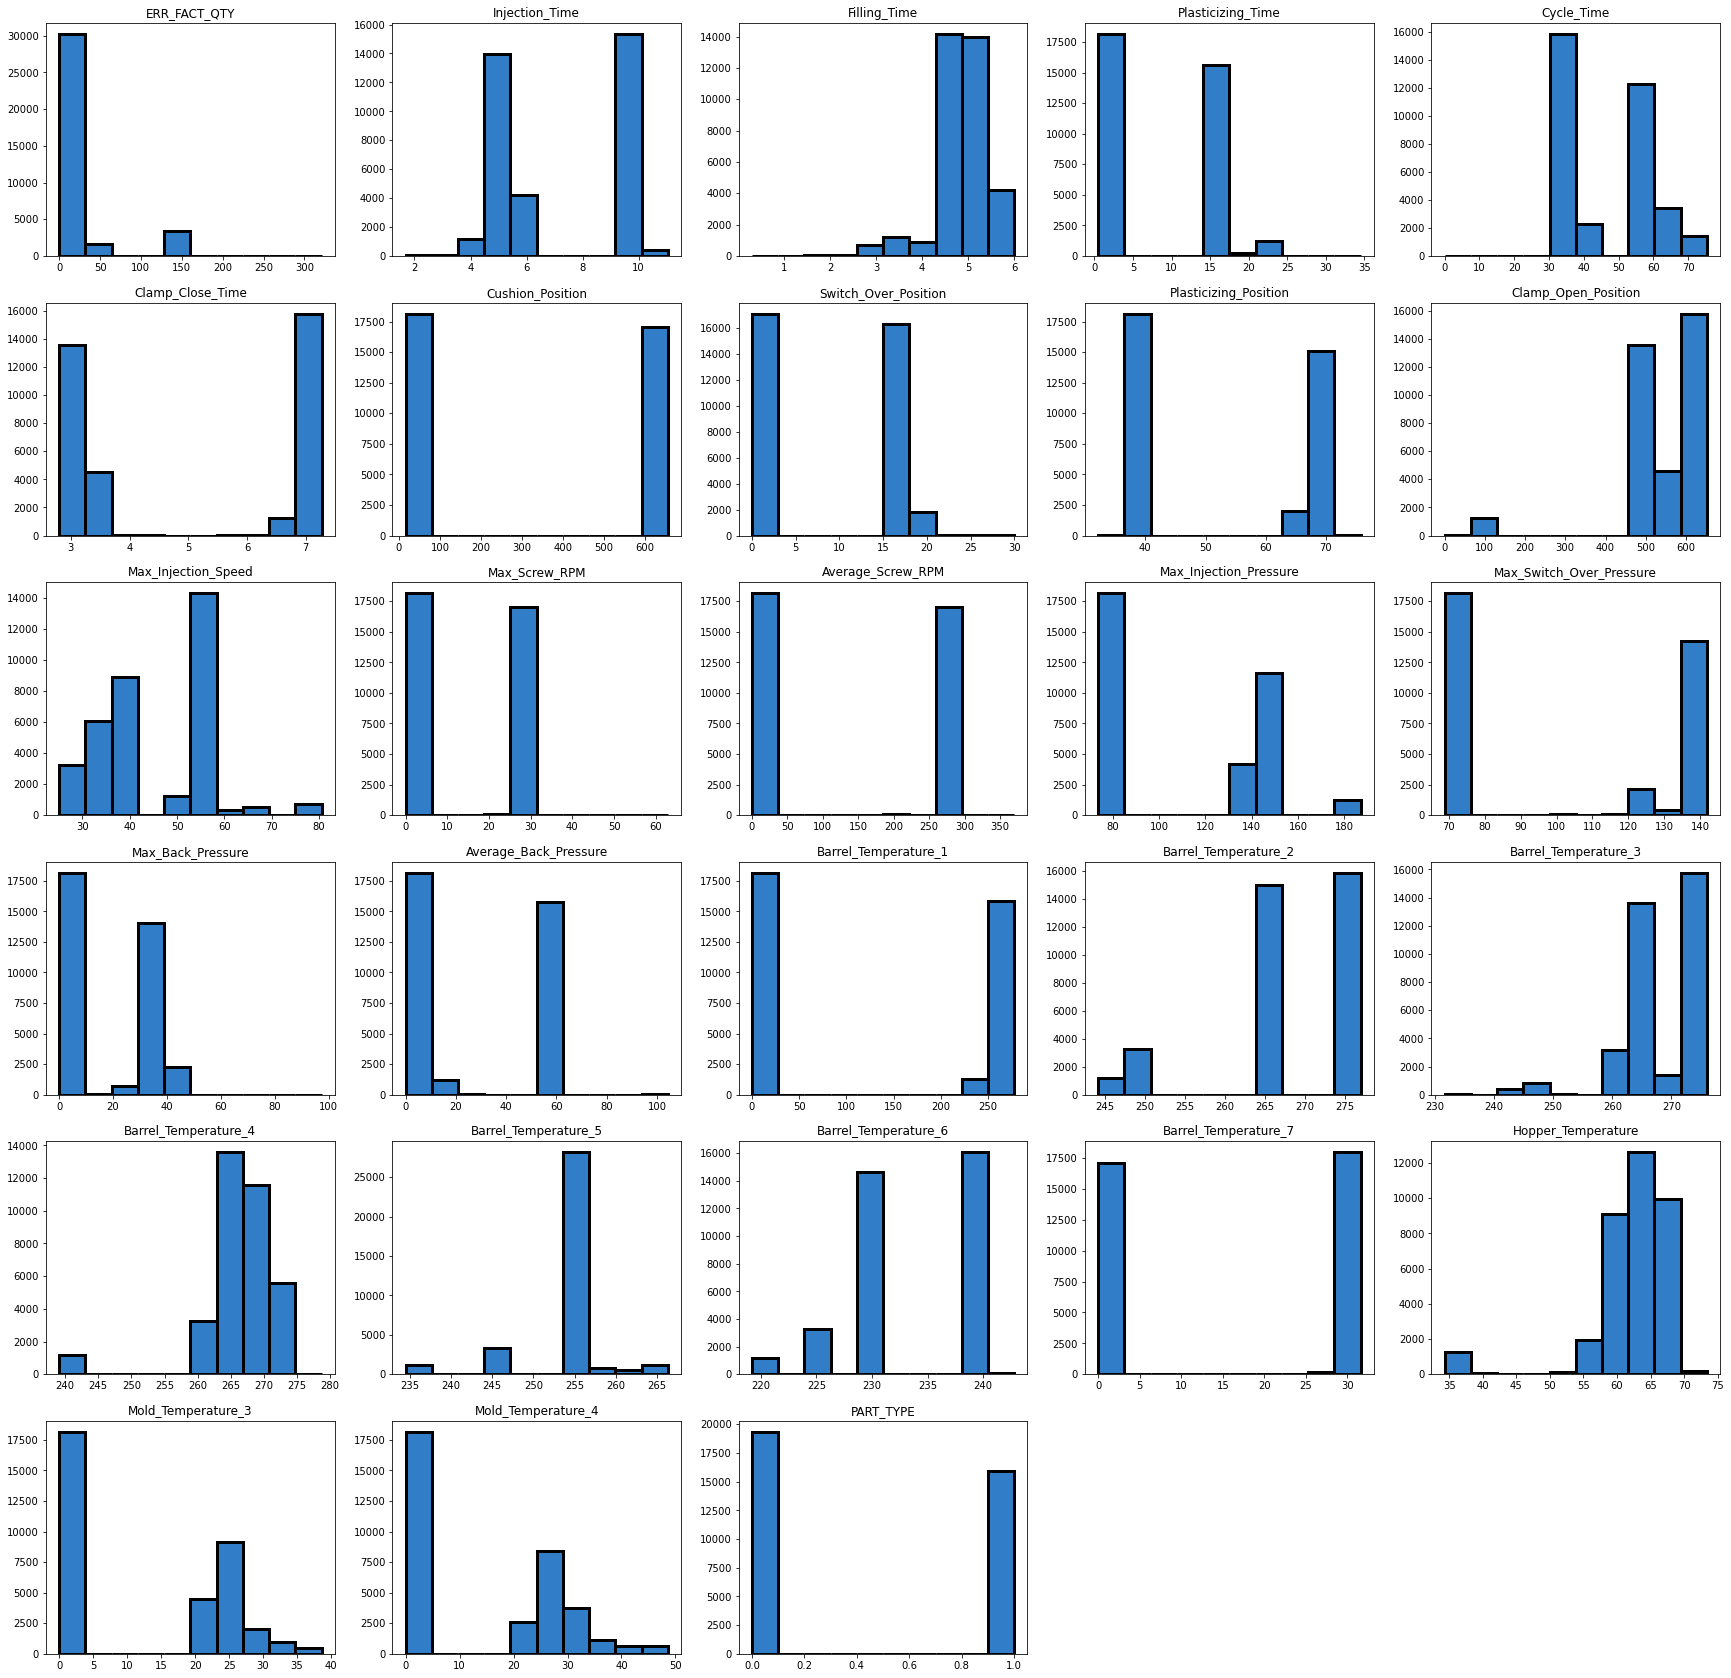

In [12]:
# 상관관계 시각화
plt.figure(figsize=(30, 30))
sns.heatmap(data=CN7_650T_1st_refine[CN7_650T_1st_refine["PART_TYPE"].isin([1])].corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

# 히스토그램 시각화
visual_CN7_650T_1st_refine = CN7_650T_1st_refine.drop("TimeStamp", axis=1)
for index, value in enumerate(visual_CN7_650T_1st_refine):
    sub = plt.subplot(6, 5, index+1)
    sub.hist(visual_CN7_650T_1st_refine[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

In [13]:
# 잡음제거 오토인코더는 정상데이터로 학습시키므로 ERR기준으로 데이터 분리
CN7_650T_1st_refine = CN7_650T_1st_refine[CN7_650T_1st_refine["ERR_FACT_QTY"] <= 0]
CN7_650T_1st_refine.drop("ERR_FACT_QTY", axis=1, inplace=True)
# 학습을 위해 Time데이터 제거
CN7_650T_1st_refine.drop("TimeStamp", axis=1, inplace=True)

In [14]:
# 데이터 특성 상 RH, LH가 조금 다르므로 데이터 분리
CN7_650T_LH = CN7_650T_1st_refine[CN7_650T_1st_refine["PART_TYPE"].isin([0])]
CN7_650T_RH = CN7_650T_1st_refine[CN7_650T_1st_refine["PART_TYPE"].isin([1])]
CN7_650T_LH.drop("PART_TYPE", axis=1, inplace=True)
CN7_650T_RH.drop("PART_TYPE", axis=1, inplace=True)

C:\Users\break\anaconda3\envs\keras\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
# 학습을 위한 스케일링
scaler = preprocessing.MinMaxScaler()
train_LH = scaler.fit_transform(CN7_650T_LH)
train_RH = scaler.fit_transform(CN7_650T_RH)

In [16]:
def denoising_autoencoder(data):
    # Encoder
    dropout_encoder = Sequential([Dropout(0.3), Dense(20, activation="swish"), Dense(10, activation="swish"), Dense(3, activation="swish")])
    # Decoder
    dropout_decoder = Sequential([Dense(10, activation="swish"), Dense(20, activation="swish"), Dense(data.shape[1], activation="swish")])
    DAE = Sequential([dropout_encoder, dropout_decoder])
    DAE.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

    return DAE

In [17]:
# 각 데이터에 DAE 적용
DAE_LH = denoising_autoencoder(train_LH)
DAE_RH = denoising_autoencoder(train_RH)

In [18]:
# 모델 훈련
history_LH = DAE_LH.fit(train_LH, train_LH, batch_size=100, epochs=500, validation_split=0.2)
history_RH = DAE_RH.fit(train_RH, train_RH, batch_size=100, epochs=500, validation_split=0.2)

Epoch 1/500
13/13 [==============================] - 4s 79ms/step - loss: 0.1941 - accuracy: 0.0154 - val_loss: 0.3815 - val_accuracy: 0.0000e+00
Epoch 2/500
13/13 [==============================] - 0s 8ms/step - loss: 0.1932 - accuracy: 0.0073 - val_loss: 0.3801 - val_accuracy: 0.0000e+00
Epoch 3/500
13/13 [==============================] - 0s 7ms/step - loss: 0.1921 - accuracy: 0.0089 - val_loss: 0.3786 - val_accuracy: 0.0000e+00
Epoch 4/500
13/13 [==============================] - 0s 7ms/step - loss: 0.1911 - accuracy: 0.0113 - val_loss: 0.3770 - val_accuracy: 0.0000e+00
Epoch 5/500
13/13 [==============================] - 0s 7ms/step - loss: 0.1900 - accuracy: 0.0113 - val_loss: 0.3753 - val_accuracy: 0.0000e+00
Epoch 6/500
13/13 [==============================] - 0s 7ms/step - loss: 0.1885 - accuracy: 0.0162 - val_loss: 0.3733 - val_accuracy: 0.0000e+00
Epoch 7/500
13/13 [==============================] - 0s 7ms/step - loss: 0.1871 - accuracy: 0.0178 - val_loss: 0.3710 - val_accur

Epoch 116/500
13/13 [==============================] - 0s 6ms/step - loss: 0.0273 - accuracy: 0.4182 - val_loss: 0.1178 - val_accuracy: 0.4207
Epoch 117/500
13/13 [==============================] - 0s 7ms/step - loss: 0.0269 - accuracy: 0.4222 - val_loss: 0.1151 - val_accuracy: 0.4207
Epoch 118/500
13/13 [==============================] - 0s 6ms/step - loss: 0.0269 - accuracy: 0.4084 - val_loss: 0.1114 - val_accuracy: 0.4207
Epoch 119/500
13/13 [==============================] - 0s 7ms/step - loss: 0.0263 - accuracy: 0.3687 - val_loss: 0.1087 - val_accuracy: 0.4207
Epoch 120/500
13/13 [==============================] - 0s 6ms/step - loss: 0.0262 - accuracy: 0.3533 - val_loss: 0.1061 - val_accuracy: 0.4207
Epoch 121/500
13/13 [==============================] - 0s 7ms/step - loss: 0.0254 - accuracy: 0.3071 - val_loss: 0.1036 - val_accuracy: 0.4207
Epoch 122/500
13/13 [==============================] - 0s 7ms/step - loss: 0.0252 - accuracy: 0.2731 - val_loss: 0.1008 - val_accuracy: 0.4207

Epoch 229/500
13/13 [==============================] - 0s 8ms/step - loss: 0.0123 - accuracy: 0.1791 - val_loss: 0.0216 - val_accuracy: 0.0000e+00
Epoch 230/500
13/13 [==============================] - 0s 7ms/step - loss: 0.0119 - accuracy: 0.1718 - val_loss: 0.0219 - val_accuracy: 0.0162
Epoch 231/500
13/13 [==============================] - 0s 7ms/step - loss: 0.0121 - accuracy: 0.1807 - val_loss: 0.0217 - val_accuracy: 0.0518
Epoch 232/500
13/13 [==============================] - 0s 8ms/step - loss: 0.0122 - accuracy: 0.1864 - val_loss: 0.0216 - val_accuracy: 0.0000e+00
Epoch 233/500
13/13 [==============================] - 0s 10ms/step - loss: 0.0124 - accuracy: 0.1937 - val_loss: 0.0214 - val_accuracy: 0.0000e+00
Epoch 234/500
13/13 [==============================] - 0s 16ms/step - loss: 0.0115 - accuracy: 0.2066 - val_loss: 0.0214 - val_accuracy: 0.0000e+00
Epoch 235/500
13/13 [==============================] - 0s 11ms/step - loss: 0.0115 - accuracy: 0.2034 - val_loss: 0.0215 - v

Epoch 286/500
13/13 [==============================] - 0s 15ms/step - loss: 0.0101 - accuracy: 0.3784 - val_loss: 0.0174 - val_accuracy: 0.1683
Epoch 287/500
13/13 [==============================] - 0s 15ms/step - loss: 0.0101 - accuracy: 0.3987 - val_loss: 0.0172 - val_accuracy: 0.1683
Epoch 288/500
13/13 [==============================] - 0s 14ms/step - loss: 0.0099 - accuracy: 0.4408 - val_loss: 0.0170 - val_accuracy: 0.1683
Epoch 289/500
13/13 [==============================] - 0s 13ms/step - loss: 0.0102 - accuracy: 0.3955 - val_loss: 0.0170 - val_accuracy: 0.1683
Epoch 290/500
13/13 [==============================] - 0s 16ms/step - loss: 0.0101 - accuracy: 0.4425 - val_loss: 0.0166 - val_accuracy: 0.1683
Epoch 291/500
13/13 [==============================] - 0s 13ms/step - loss: 0.0096 - accuracy: 0.4579 - val_loss: 0.0164 - val_accuracy: 0.1683
Epoch 292/500
13/13 [==============================] - 0s 13ms/step - loss: 0.0097 - accuracy: 0.4335 - val_loss: 0.0164 - val_accuracy:

Epoch 343/500
13/13 [==============================] - 0s 10ms/step - loss: 0.0061 - accuracy: 0.7123 - val_loss: 0.0070 - val_accuracy: 0.1683
Epoch 344/500
13/13 [==============================] - 0s 14ms/step - loss: 0.0065 - accuracy: 0.7026 - val_loss: 0.0064 - val_accuracy: 0.1683
Epoch 345/500
13/13 [==============================] - 0s 12ms/step - loss: 0.0061 - accuracy: 0.7237 - val_loss: 0.0063 - val_accuracy: 0.1683
Epoch 346/500
13/13 [==============================] - 0s 7ms/step - loss: 0.0062 - accuracy: 0.7269 - val_loss: 0.0062 - val_accuracy: 0.1683
Epoch 347/500
13/13 [==============================] - 0s 7ms/step - loss: 0.0060 - accuracy: 0.7139 - val_loss: 0.0062 - val_accuracy: 0.1683
Epoch 348/500
13/13 [==============================] - 0s 6ms/step - loss: 0.0061 - accuracy: 0.7261 - val_loss: 0.0060 - val_accuracy: 0.1683
Epoch 349/500
13/13 [==============================] - 0s 6ms/step - loss: 0.0060 - accuracy: 0.7204 - val_loss: 0.0061 - val_accuracy: 0.1

13/13 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.81 - 0s 13ms/step - loss: 0.0044 - accuracy: 0.7788 - val_loss: 0.0032 - val_accuracy: 0.1683
Epoch 401/500
13/13 [==============================] - 0s 7ms/step - loss: 0.0047 - accuracy: 0.7958 - val_loss: 0.0031 - val_accuracy: 0.1683
Epoch 402/500
13/13 [==============================] - 0s 10ms/step - loss: 0.0045 - accuracy: 0.7925 - val_loss: 0.0032 - val_accuracy: 0.1683
Epoch 403/500
13/13 [==============================] - 0s 13ms/step - loss: 0.0044 - accuracy: 0.7812 - val_loss: 0.0031 - val_accuracy: 0.1683
Epoch 404/500
13/13 [==============================] - 0s 8ms/step - loss: 0.0045 - accuracy: 0.7917 - val_loss: 0.0030 - val_accuracy: 0.1683
Epoch 405/500
13/13 [==============================] - 0s 11ms/step - loss: 0.0041 - accuracy: 0.7828 - val_loss: 0.0030 - val_accuracy: 0.1683
Epoch 406/500
13/13 [==============================] - 0s 9ms/step - loss: 0.0044 - accuracy: 0.7780 - val_los

Epoch 457/500
13/13 [==============================] - 0s 18ms/step - loss: 0.0035 - accuracy: 0.7966 - val_loss: 0.0026 - val_accuracy: 0.1683
Epoch 458/500
13/13 [==============================] - 0s 15ms/step - loss: 0.0034 - accuracy: 0.8096 - val_loss: 0.0027 - val_accuracy: 0.1683
Epoch 459/500
13/13 [==============================] - 0s 14ms/step - loss: 0.0036 - accuracy: 0.8152 - val_loss: 0.0028 - val_accuracy: 0.1683
Epoch 460/500
13/13 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.81 - 0s 15ms/step - loss: 0.0037 - accuracy: 0.8120 - val_loss: 0.0026 - val_accuracy: 0.1683
Epoch 461/500
13/13 [==============================] - 0s 17ms/step - loss: 0.0038 - accuracy: 0.8015 - val_loss: 0.0025 - val_accuracy: 0.1683
Epoch 462/500
13/13 [==============================] - 0s 15ms/step - loss: 0.0036 - accuracy: 0.7982 - val_loss: 0.0024 - val_accuracy: 0.1683
Epoch 463/500
13/13 [==============================] - 0s 15ms/step - loss: 0.0038 - accuracy:

26/26 [==============================] - 0s 10ms/step - loss: 0.0134 - accuracy: 0.2586 - val_loss: 0.0058 - val_accuracy: 0.0000e+00
Epoch 70/500
26/26 [==============================] - 0s 11ms/step - loss: 0.0129 - accuracy: 0.2484 - val_loss: 0.0062 - val_accuracy: 0.0000e+00
Epoch 71/500
26/26 [==============================] - 0s 11ms/step - loss: 0.0129 - accuracy: 0.2771 - val_loss: 0.0056 - val_accuracy: 0.0000e+00
Epoch 72/500
26/26 [==============================] - 0s 12ms/step - loss: 0.0121 - accuracy: 0.2700 - val_loss: 0.0056 - val_accuracy: 0.0000e+00
Epoch 73/500
26/26 [==============================] - 0s 11ms/step - loss: 0.0121 - accuracy: 0.2724 - val_loss: 0.0055 - val_accuracy: 0.0000e+00
Epoch 74/500
26/26 [==============================] - 0s 11ms/step - loss: 0.0117 - accuracy: 0.2669 - val_loss: 0.0056 - val_accuracy: 0.0000e+00
Epoch 75/500
26/26 [==============================] - 0s 11ms/step - loss: 0.0122 - accuracy: 0.2798 - val_loss: 0.0054 - val_accur

Epoch 125/500
26/26 [==============================] - 0s 6ms/step - loss: 0.0054 - accuracy: 0.2437 - val_loss: 0.0050 - val_accuracy: 0.0000e+00
Epoch 126/500
26/26 [==============================] - 0s 5ms/step - loss: 0.0057 - accuracy: 0.2378 - val_loss: 0.0049 - val_accuracy: 0.0000e+00
Epoch 127/500
26/26 [==============================] - 0s 5ms/step - loss: 0.0055 - accuracy: 0.2480 - val_loss: 0.0048 - val_accuracy: 0.0000e+00
Epoch 128/500
26/26 [==============================] - 0s 5ms/step - loss: 0.0054 - accuracy: 0.2280 - val_loss: 0.0050 - val_accuracy: 0.0000e+00
Epoch 129/500
26/26 [==============================] - 0s 5ms/step - loss: 0.0053 - accuracy: 0.2374 - val_loss: 0.0049 - val_accuracy: 0.0000e+00
Epoch 130/500
26/26 [==============================] - 0s 5ms/step - loss: 0.0052 - accuracy: 0.2406 - val_loss: 0.0051 - val_accuracy: 0.0000e+00
Epoch 131/500
26/26 [==============================] - 0s 5ms/step - loss: 0.0054 - accuracy: 0.2449 - val_loss: 0.005

Epoch 181/500
26/26 [==============================] - 0s 6ms/step - loss: 0.0038 - accuracy: 0.3658 - val_loss: 0.0047 - val_accuracy: 0.0000e+00
Epoch 182/500
26/26 [==============================] - 0s 6ms/step - loss: 0.0037 - accuracy: 0.4301 - val_loss: 0.0049 - val_accuracy: 0.0000e+00
Epoch 183/500
26/26 [==============================] - 0s 5ms/step - loss: 0.0037 - accuracy: 0.3842 - val_loss: 0.0047 - val_accuracy: 0.0000e+00
Epoch 184/500
26/26 [==============================] - 0s 4ms/step - loss: 0.0036 - accuracy: 0.4337 - val_loss: 0.0046 - val_accuracy: 0.0000e+00
Epoch 185/500
26/26 [==============================] - 0s 4ms/step - loss: 0.0036 - accuracy: 0.3921 - val_loss: 0.0047 - val_accuracy: 0.0000e+00
Epoch 186/500
26/26 [==============================] - 0s 5ms/step - loss: 0.0035 - accuracy: 0.4188 - val_loss: 0.0049 - val_accuracy: 0.0000e+00
Epoch 187/500
26/26 [==============================] - 0s 4ms/step - loss: 0.0037 - accuracy: 0.4038 - val_loss: 0.004

Epoch 237/500
26/26 [==============================] - 0s 4ms/step - loss: 0.0029 - accuracy: 0.4765 - val_loss: 0.0045 - val_accuracy: 0.0000e+00
Epoch 238/500
26/26 [==============================] - 0s 5ms/step - loss: 0.0029 - accuracy: 0.4757 - val_loss: 0.0045 - val_accuracy: 0.0000e+00
Epoch 239/500
26/26 [==============================] - 0s 6ms/step - loss: 0.0029 - accuracy: 0.4863 - val_loss: 0.0046 - val_accuracy: 0.0000e+00
Epoch 240/500
26/26 [==============================] - 0s 6ms/step - loss: 0.0029 - accuracy: 0.4784 - val_loss: 0.0045 - val_accuracy: 0.1489
Epoch 241/500
26/26 [==============================] - 0s 6ms/step - loss: 0.0029 - accuracy: 0.4749 - val_loss: 0.0045 - val_accuracy: 0.0000e+00
Epoch 242/500
26/26 [==============================] - 0s 6ms/step - loss: 0.0028 - accuracy: 0.4859 - val_loss: 0.0045 - val_accuracy: 0.0000e+00
Epoch 243/500
26/26 [==============================] - 0s 7ms/step - loss: 0.0028 - accuracy: 0.4745 - val_loss: 0.0045 - 

Epoch 293/500
26/26 [==============================] - 0s 8ms/step - loss: 0.0025 - accuracy: 0.5530 - val_loss: 0.0044 - val_accuracy: 0.0000e+00
Epoch 294/500
26/26 [==============================] - 0s 12ms/step - loss: 0.0026 - accuracy: 0.5200 - val_loss: 0.0043 - val_accuracy: 0.0000e+00
Epoch 295/500
26/26 [==============================] - 0s 10ms/step - loss: 0.0025 - accuracy: 0.5310 - val_loss: 0.0043 - val_accuracy: 0.0204
Epoch 296/500
26/26 [==============================] - 0s 7ms/step - loss: 0.0025 - accuracy: 0.5377 - val_loss: 0.0042 - val_accuracy: 0.3950
Epoch 297/500
26/26 [==============================] - 0s 7ms/step - loss: 0.0024 - accuracy: 0.5216 - val_loss: 0.0043 - val_accuracy: 0.0000e+00
Epoch 298/500
26/26 [==============================] - 0s 7ms/step - loss: 0.0025 - accuracy: 0.5228 - val_loss: 0.0043 - val_accuracy: 0.0000e+00
Epoch 299/500
26/26 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.5255 - val_loss: 0.0042 - v

Epoch 406/500
26/26 [==============================] - 0s 6ms/step - loss: 0.0021 - accuracy: 0.5985 - val_loss: 0.0042 - val_accuracy: 0.3950
Epoch 407/500
26/26 [==============================] - 0s 6ms/step - loss: 0.0021 - accuracy: 0.5977 - val_loss: 0.0040 - val_accuracy: 0.3950
Epoch 408/500
26/26 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.5946 - val_loss: 0.0041 - val_accuracy: 0.3950
Epoch 409/500
26/26 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.5871 - val_loss: 0.0040 - val_accuracy: 0.3950
Epoch 410/500
26/26 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.5981 - val_loss: 0.0039 - val_accuracy: 0.3950
Epoch 411/500
26/26 [==============================] - 0s 8ms/step - loss: 0.0021 - accuracy: 0.5997 - val_loss: 0.0040 - val_accuracy: 0.3950
Epoch 412/500
26/26 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.6150 - val_loss: 0.0039 - val_accuracy: 0.3950

In [19]:
# 훈련격과 시각화 함수
def training_visualize(model_his):
    sub = plt.subplot(2, 1, 1)
    # 훈련 결과 시각화
    sub.plot(model_his.history["loss"], label="Training Loss")
    sub.plot(model_his.history["val_loss"], label="Validation Loss")
    sub.legend()
    sub = plt.subplot(2, 1, 2)
    sub.plot(model_his.history["accuracy"], label="Training Acc")
    sub.plot(model_his.history["val_accuracy"], label="Validation Acc")
    sub.legend()

C:\Users\break\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\break\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


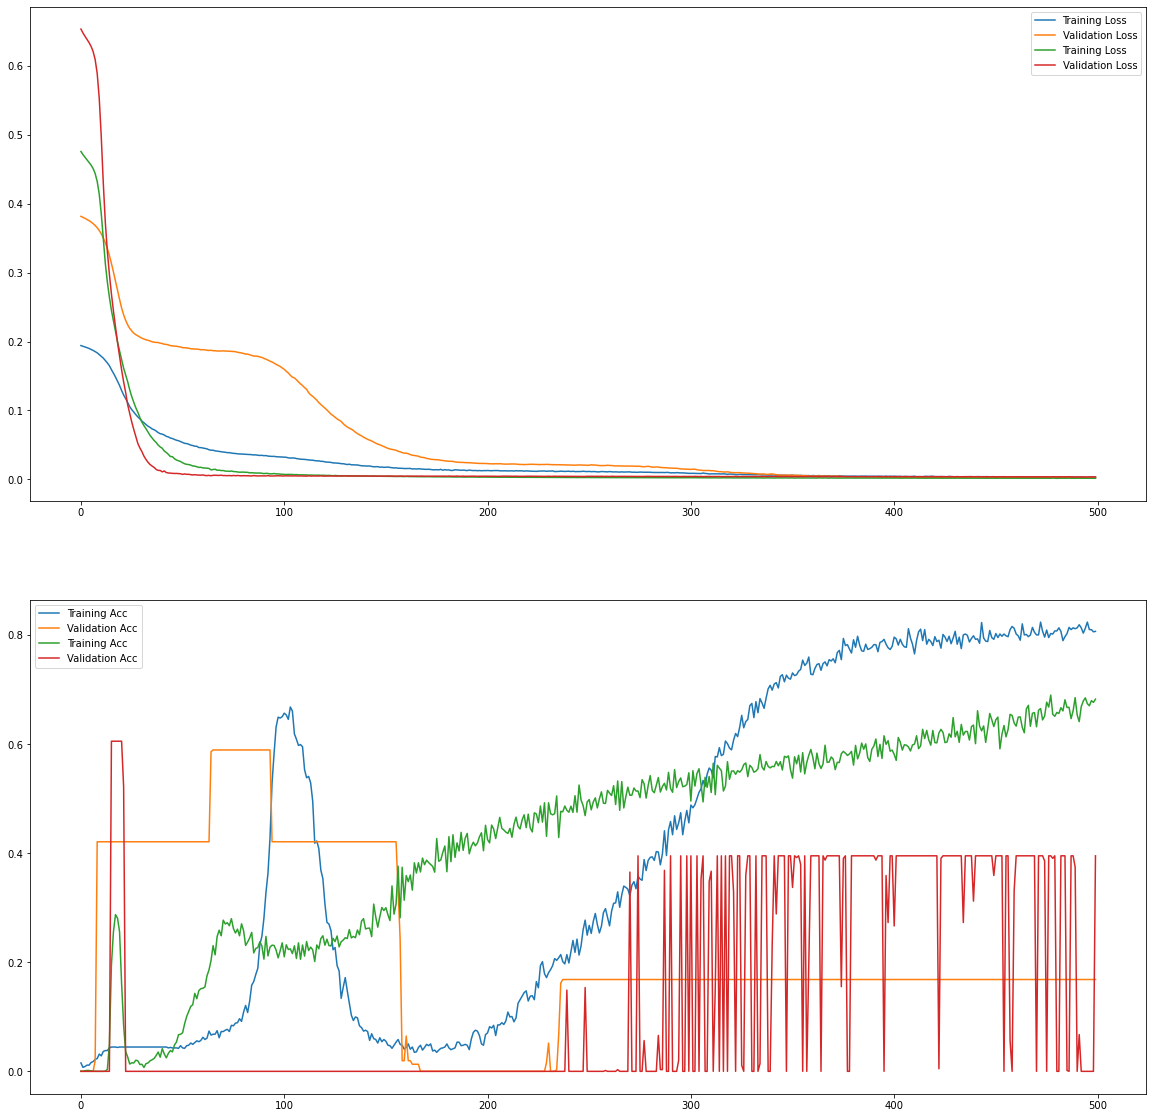

In [20]:
# 데이터 별 훈련결과 시각화
training_visualize(history_LH)
training_visualize(history_RH)

In [21]:
def defective_decision(DAE, train_data, test_data):
    # 학습 데이터 예측값
    pred = DAE.predict(train_data)
    # 학습 데이터 복원 오차
    train_loss = np.mean(np.square(pred-train_data), axis=1)
    #임계치 (3시그마-99.7%)
    threshold = np.mean(train_loss) + 3*np.std(train_loss)

    # 평가 데이터
    # 예측값
    pred_def = DAE.predict(test_data)
    # 복원오차
    test_loss = np.mean(np.square(pred_def - test_data), axis=1)

    defect = test_loss > threshold
    print("불량 개수: ", np.sum(defect))
    
    return defect

In [22]:
# 레이블 데이터 전 처리
test_df = div_pa_eq(labeled_df, "CN7", "650톤-우진2호기")
test_df = test_df.drop(["TimeStamp", "PART_FACT_SERIAL", "EQUIP_CD", "EQUIP_NAME", "Reason"], axis=1)

test_LH = test_df[test_df["PART_NAME"].str.contains("LH")]
test_LH.drop("PART_NAME", axis=1, inplace=True)
test_LH_Y = test_LH[test_LH["PassOrFail"].str.contains("Y")]
test_LH_Y.drop("PassOrFail", axis=1, inplace=True)
test_LH_N = test_LH[test_LH["PassOrFail"].str.contains("N")]
test_LH_N.drop("PassOrFail", axis=1, inplace=True)

test_RH = test_df[test_df["PART_NAME"].str.contains("RH")]
test_RH.drop("PART_NAME", axis=1, inplace=True)
test_RH_Y = test_RH[test_RH["PassOrFail"].str.contains("Y")]
test_RH_Y.drop("PassOrFail", axis=1, inplace=True)
test_RH_N = test_RH[test_RH["PassOrFail"].str.contains("N")]
test_RH_N.drop("PassOrFail", axis=1, inplace=True)

test_LH_Y = scaler.fit_transform(test_LH_Y)
test_LH_N = scaler.fit_transform(test_LH_N)

test_LH_Y = scaler.fit_transform(test_RH_Y)
test_RH_N = scaler.fit_transform(test_RH_N)

C:\Users\break\anaconda3\envs\keras\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [23]:
# LH 확인
print(f"테스트 데이터 개수: {len(test_RH_Y)}")
defective_decision(DAE_RH, train_RH, test_RH_Y)

테스트 데이터 개수: 1971
불량 개수:  1971


0       True
1       True
4       True
5       True
7       True
        ... 
5148    True
5150    True
5152    True
5154    True
5157    True
Length: 1971, dtype: bool

In [24]:
# CN7_우진650톤 데이터 추출
CN7_filter = unlabeled_df["PART_NAME"].str.contains("CN7")
Eq650_filter = unlabeled_df["EQUIP_NAME"].str.contains("650")
CN7_650T_df = unlabeled_df[CN7_filter & Eq650_filter]
CN7_650T_1st_refine = CN7_650T_df.drop(["PART_FACT_SERIAL", "PART_NO", "PART_NAME", "EQUIP_CD", "EQUIP_NAME"], axis=1)
# 잡음제거 오토인코더는 정상데이터로 학습시키므로 ERR기준으로 데이터 분리
CN7_650T_1st_refine = CN7_650T_1st_refine[CN7_650T_1st_refine["ERR_FACT_QTY"] <= 0]
# CN7_650T_1st_refine.drop("ERR_FACT_QTY", axis=1, inplace=True)
# 학습을 위해 Time데이터 제거
CN7_650T_1st_refine.drop("TimeStamp", axis=1, inplace=True)

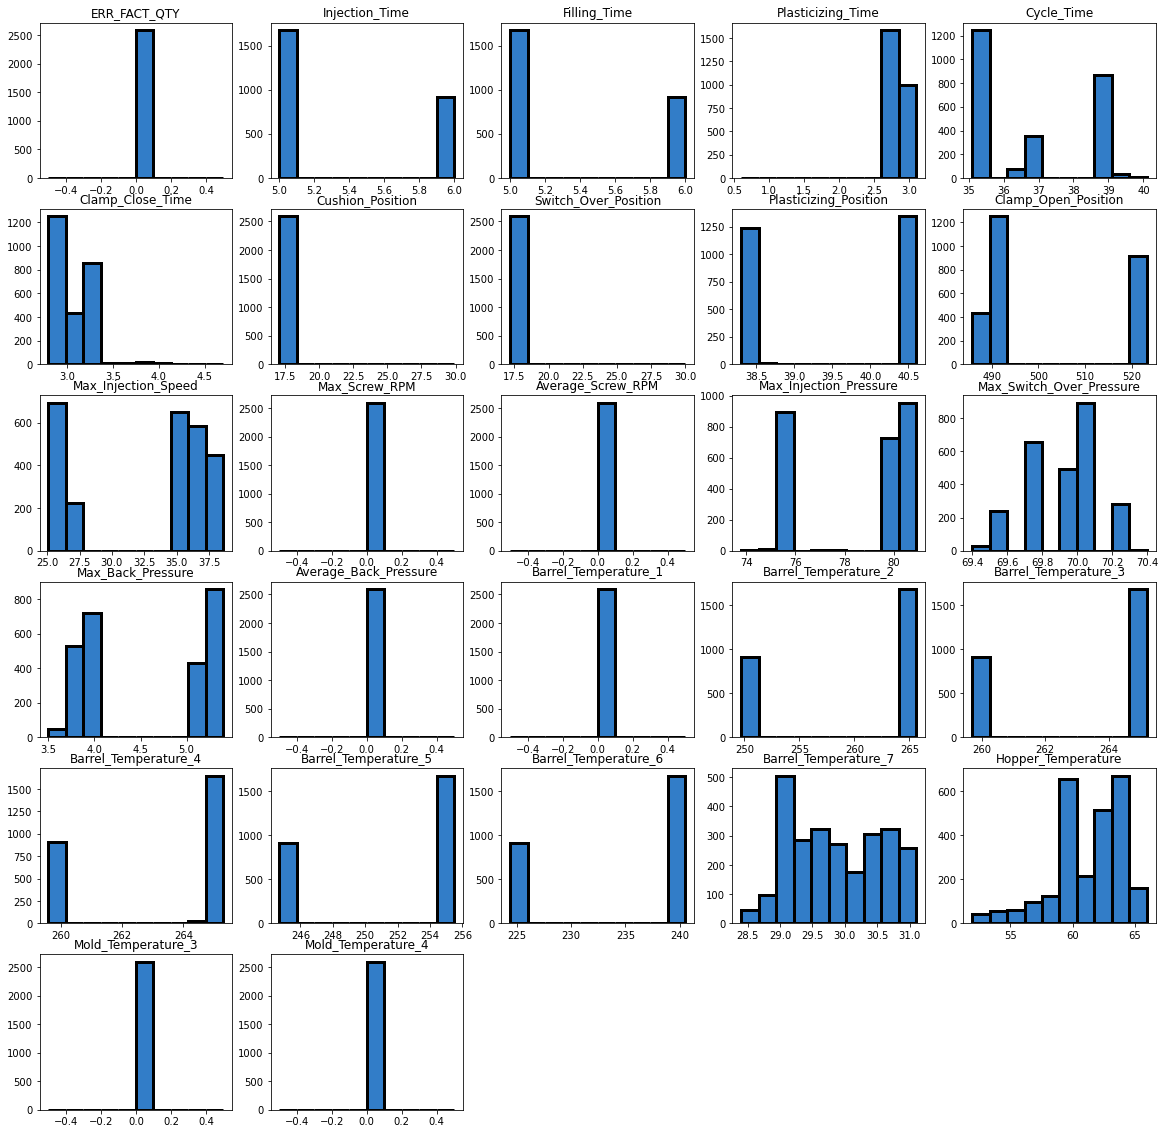

In [26]:
# 히스토그램 시각화
# CN7_650T_1st_refine - 나누기 전
# CN7_650T_LH, CN7_650T_RH
# CN7_650T_1st_refine[CN7_650T_1st_refine["Plasticizing_Time"] < 5]
# CN7_650T_1st_refine.drop["Max_Screw_RPM","Average_Screw_RPM", axis=1]
# CN7_650T_1st_refine[CN7_650T_1st_refine["ERR_FACT_QTY"] < 5]
# CN7_650T_1st_refine[CN7_650T_1st_refine["Max_Injection_Pressure"] < 100]
## CN7_650T_1st_refine[CN7_650T_1st_refine["Max_Injection_Pressure"] > 100]

data = CN7_650T_1st_refine[CN7_650T_1st_refine["Switch_Over_Position"] != 0]
for index, value in enumerate(data):
    sub = plt.subplot(6, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

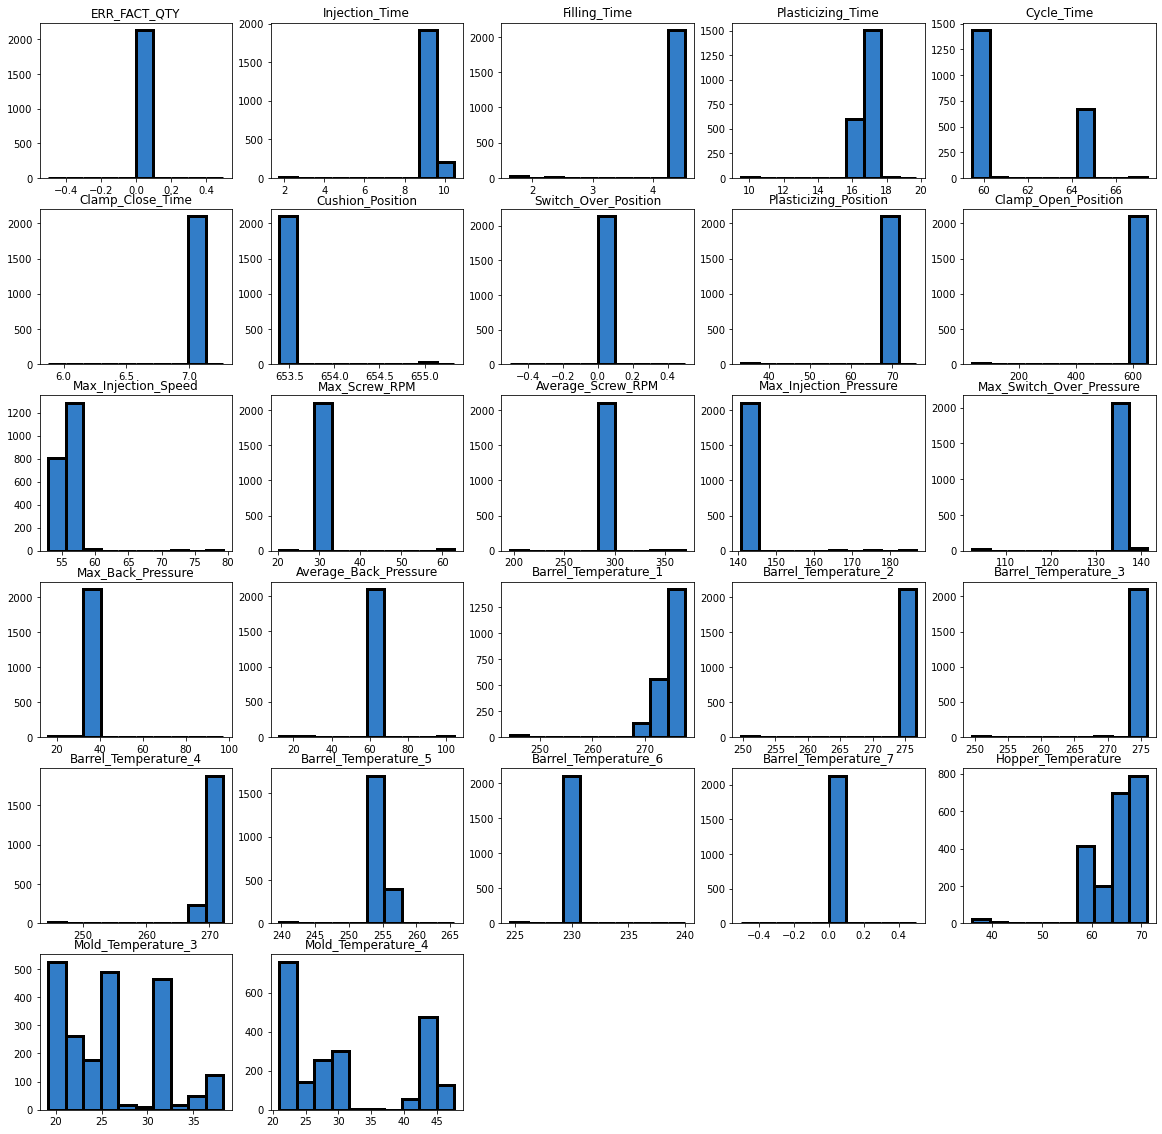

In [25]:
# 히스토그램 시각화
# CN7_650T_1st_refine - 나누기 전
# CN7_650T_LH, CN7_650T_RH
# CN7_650T_1st_refine[CN7_650T_1st_refine["Plasticizing_Time"] < 5]
# CN7_650T_1st_refine.drop["Max_Screw_RPM","Average_Screw_RPM", axis=1]
# CN7_650T_1st_refine[CN7_650T_1st_refine["ERR_FACT_QTY"] < 5]
# CN7_650T_1st_refine[CN7_650T_1st_refine["Max_Injection_Pressure"] < 100]
## CN7_650T_1st_refine[CN7_650T_1st_refine["Max_Injection_Pressure"] > 100]

data = CN7_650T_1st_refine[CN7_650T_1st_refine["Switch_Over_Position"] == 0]
for index, value in enumerate(data):
    sub = plt.subplot(6, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

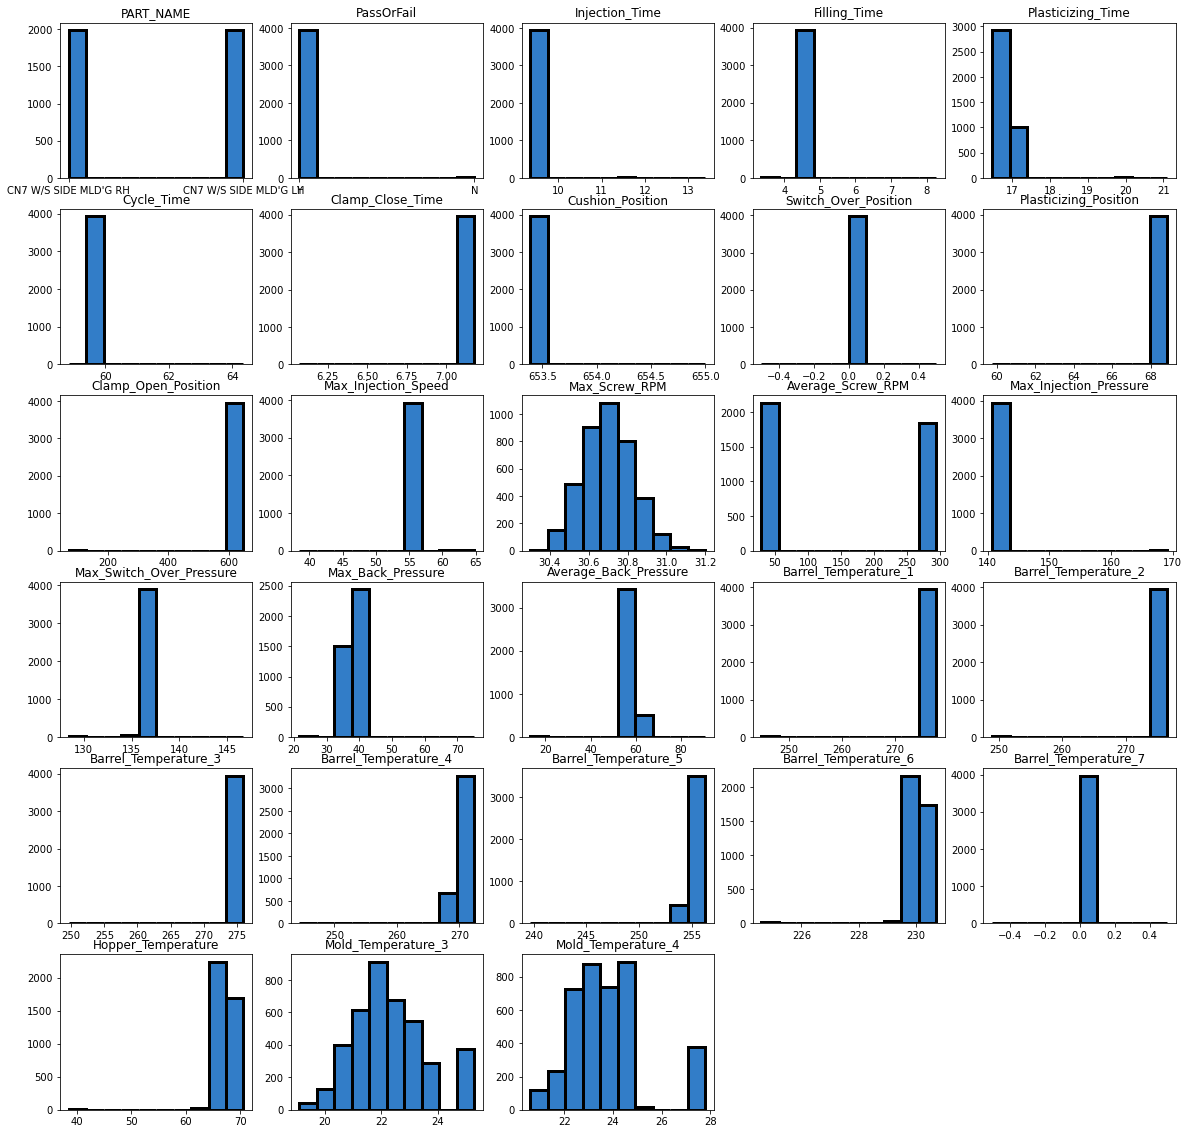

In [28]:
# 히스토그램 시각화
# test_df - 나누기 전

data = test_df[test_df["Switch_Over_Position"] == 0]
for index, value in enumerate(data):
    sub = plt.subplot(6, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

C:\Users\break\anaconda3\envs\keras\lib\site-packages\seaborn\distributions.py:2163: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
C:\Users\break\anaconda3\envs\keras\lib\site-packages\seaborn\distributions.py:2163: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
C:\Users\break\anaconda3\envs\keras\lib\site-packages\seaborn\distributions.py:2163: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
C:\Users\break\anaconda3\envs\keras\lib\site-packages\seaborn\distributions.py:2163: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
C:\Users\break\anaconda3\envs\keras\lib\site-package

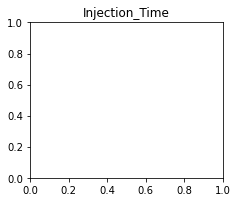

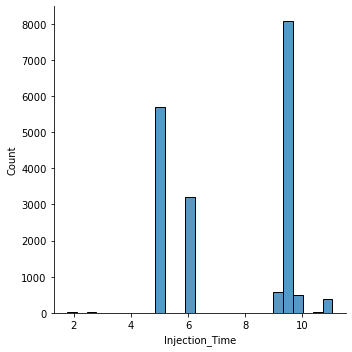

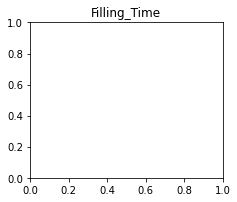

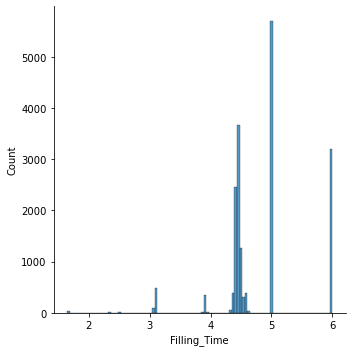

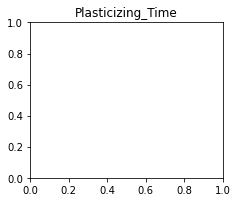

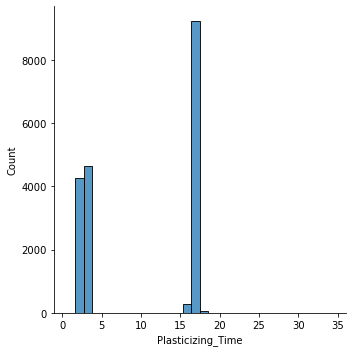

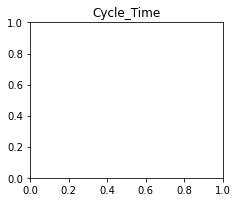

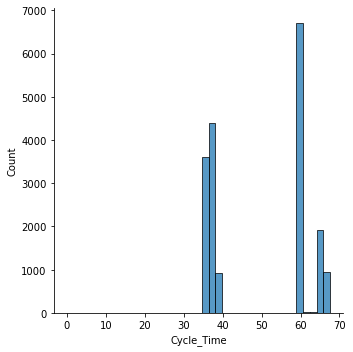

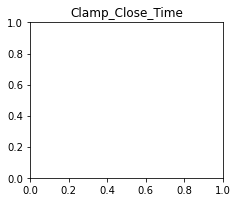

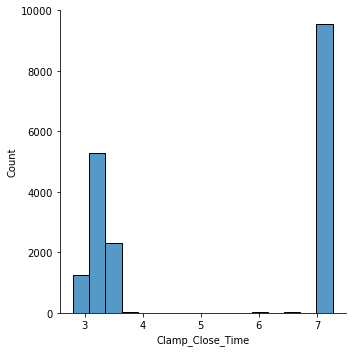

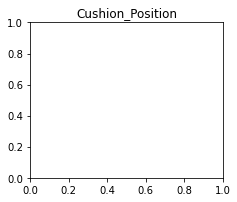

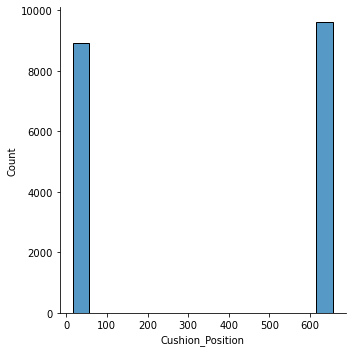

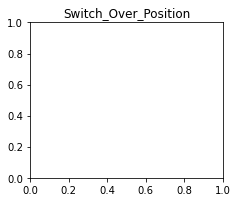

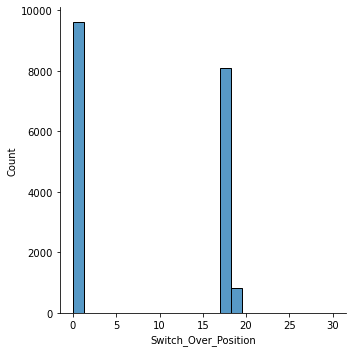

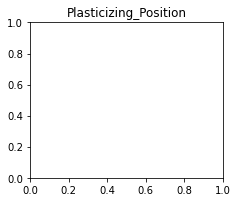

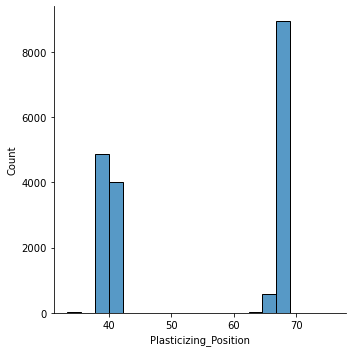

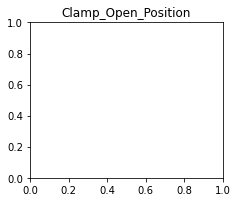

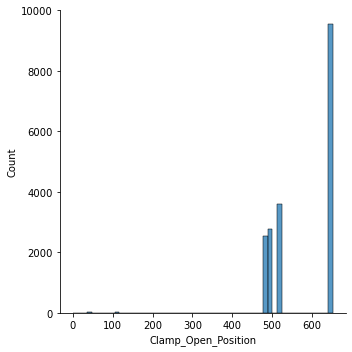

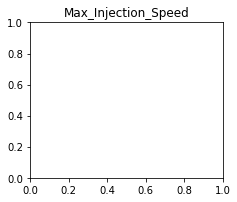

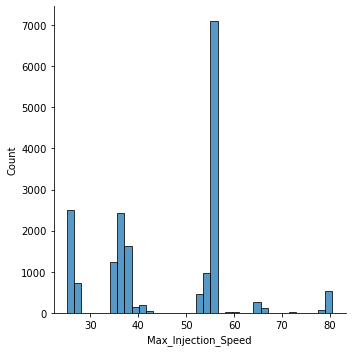

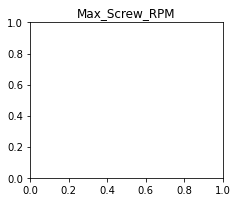

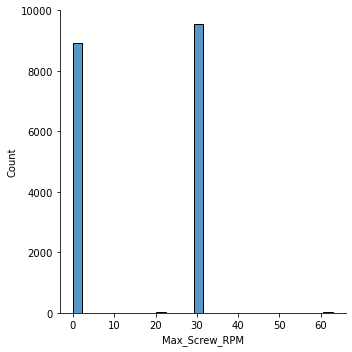

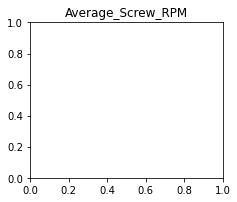

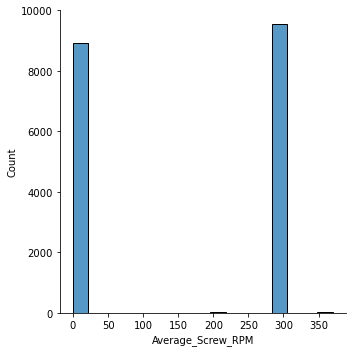

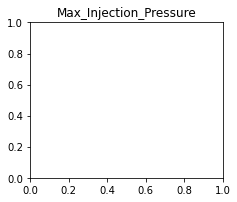

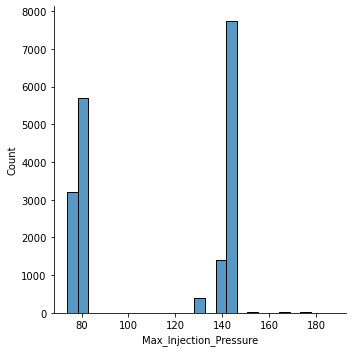

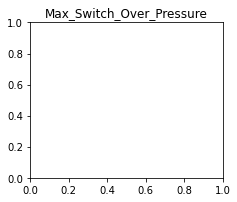

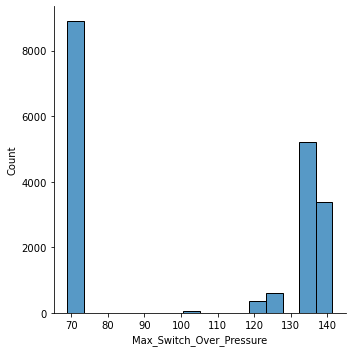

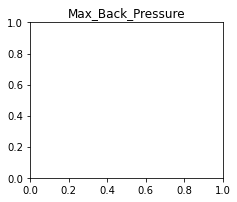

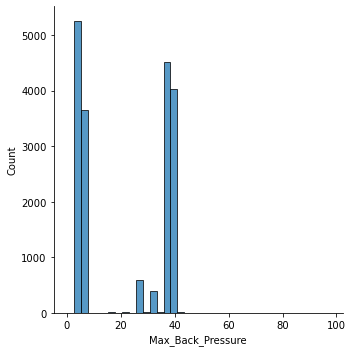

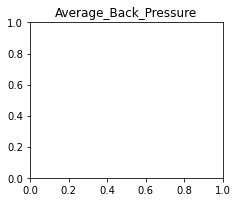

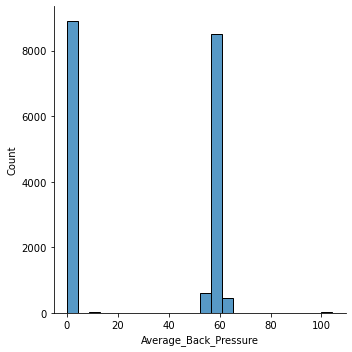

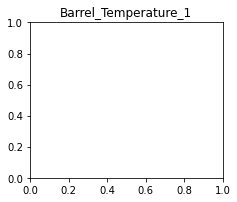

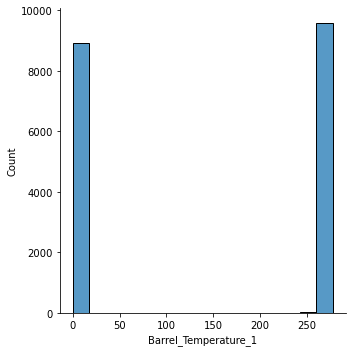

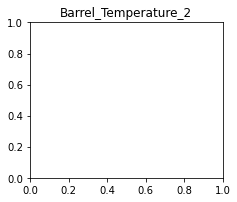

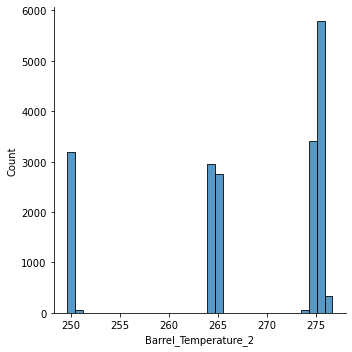

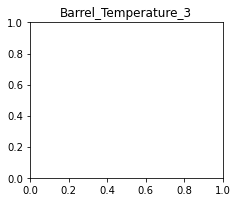

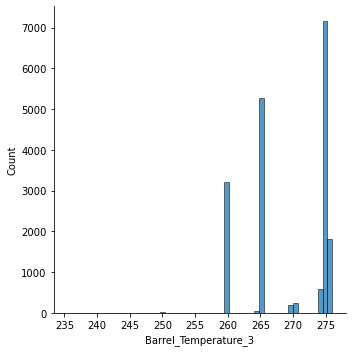

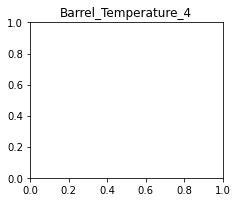

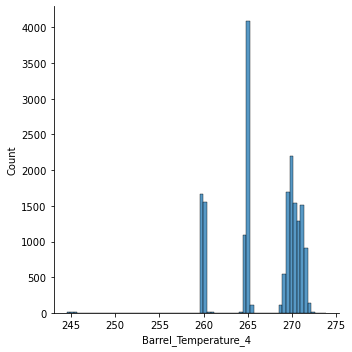

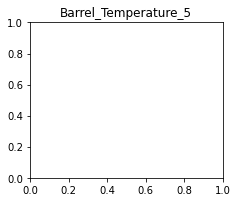

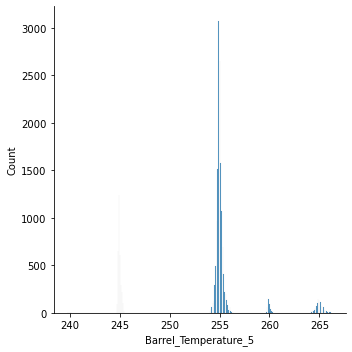

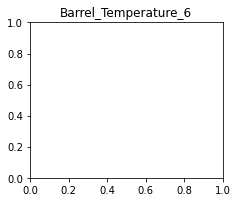

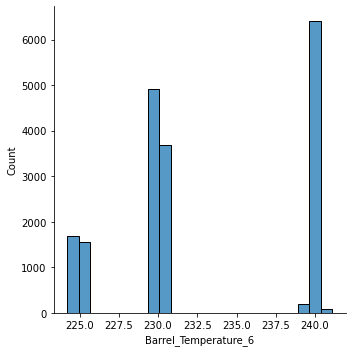

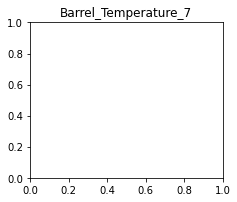

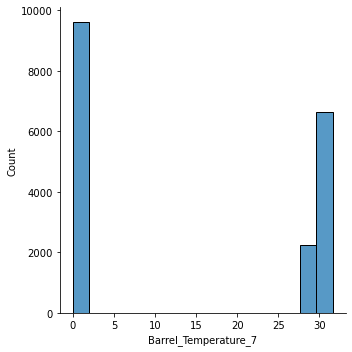

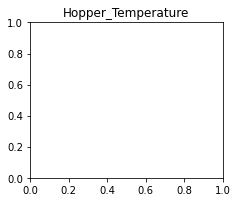

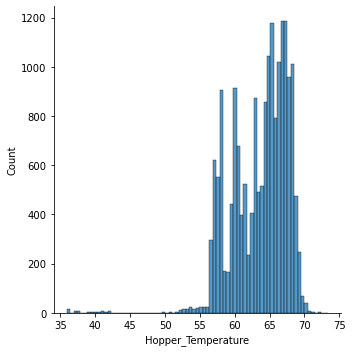

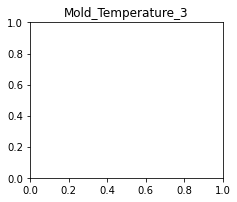

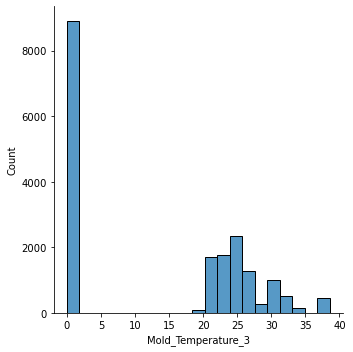

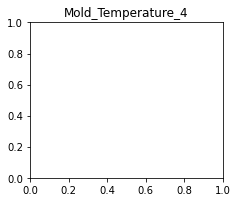

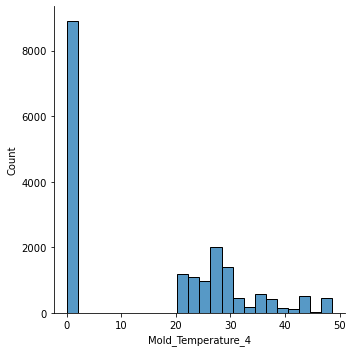

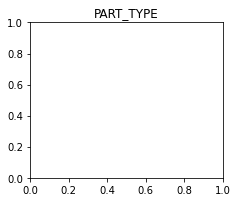

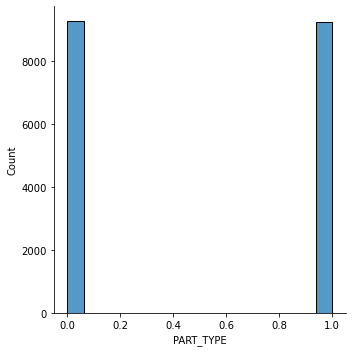

In [88]:
# 히스토그램 시각화
# CN7_650T_1st_refine - 나누기 전
# CN7_650T_LH, CN7_650T_RH
for index, value in enumerate(CN7_650T_1st_refine):
    fig = plt.figure()
    sub = fig.add_subplot(6, 5, index+1)
    sns.displot(CN7_650T_1st_refine[value], ax=sub)
    sub.set_title(value)